In [135]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [136]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [137]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [138]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [139]:
tf.keras.backend.clear_session()

In [140]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 179 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [141]:
data = pd.read_csv('2003_raw_Alagoas_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - População,Alagoas - INCC (%),Alagoas - IPCA - Variação mensal durante o Plano Real (%),Alagoas - IGP-DI,Alagoas - Taxa Selic (%),Alagoas - IDH - Longevidade,Alagoas - IDH - Renda,Alagoas - IDH - Educação,Alagoas - NFSP - Fluxo Mensal (Milhões de reais),Alagoas - Estoque liquido de capital fixo - (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - Valor,Alagoas - Consumo de Cimento (t)
0,2003-01-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.70,12.53,2.70,0.082293,0.647,0.574,0.282,3.46,6.098524e+06,9.080515,NaN,0.31,30109.0
1,2003-02-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.51,2.25,2.17,0.088771,0.647,0.574,0.282,3.59,6.172460e+06,9.080515,NaN,0.33,27684.0
2,2003-03-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.39,3.86,1.59,0.090733,0.647,0.574,0.282,3.84,6.172460e+06,9.080515,NaN,0.34,26534.0
3,2003-04-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,1.38,5.13,1.66,0.092749,0.647,0.574,0.282,3.95,6.172460e+06,9.080515,43412.0,0.34,25109.0
4,2003-05-01,1.677938e+06,8.832433e+05,0.581097,1.037095e+06,2887535.0,0.90,6.15,0.41,0.092758,0.647,0.574,0.282,4.06,6.172460e+06,9.080515,151995.0,0.34,25171.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,2.414659e+06,4.074356e+06,0.726690,1.188205e+06,3322820.0,0.58,2.42,-0.01,0.024620,0.780,0.640,0.640,0.69,7.827728e+06,12.300000,582808.0,0.45,32378.0
200,2019-09-01,2.414659e+06,4.074356e+06,0.726690,1.188205e+06,3322820.0,0.42,2.54,-0.51,0.022751,0.780,0.640,0.640,0.62,7.827728e+06,12.000000,71244.0,0.45,32582.0
201,2019-10-01,2.414659e+06,4.074356e+06,0.726690,1.188205e+06,3322820.0,0.46,2.49,0.50,0.022035,0.780,0.640,0.640,0.59,7.827728e+06,11.900000,206383.0,0.45,42703.0
202,2019-11-01,2.414659e+06,4.074356e+06,0.726690,1.188205e+06,3322820.0,0.18,2.60,0.55,0.020790,0.780,0.640,0.640,0.57,7.827728e+06,11.700000,107358.0,0.45,38584.0


In [142]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 204, dtype: float64

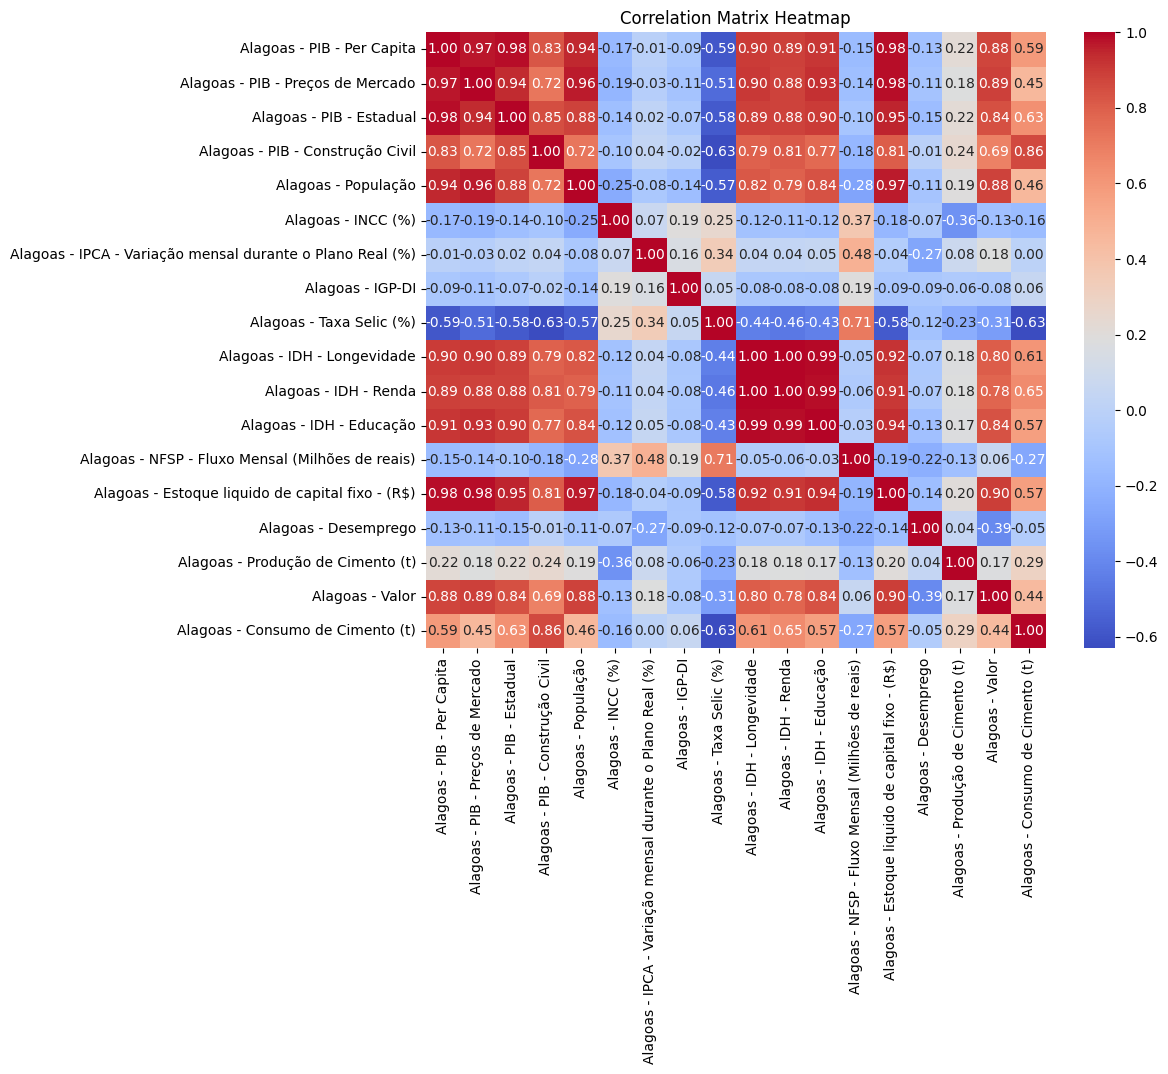

In [143]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [144]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(-1.0)
input_data

,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - População,Alagoas - INCC (%),Alagoas - IPCA - Variação mensal durante o Plano Real (%),Alagoas - IGP-DI,Alagoas - Taxa Selic (%),Alagoas - IDH - Longevidade,Alagoas - IDH - Renda,Alagoas - IDH - Educação,Alagoas - NFSP - Fluxo Mensal (Milhões de reais),Alagoas - Estoque liquido de capital fixo - (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - Valor
0,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.998868,4.052332,3.466715,2.303195,-0.929391,-0.933555,-0.918391,3.108599,-1.539424,-0.188245,-1.000000,-1.085375
1,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.647487,-0.596188,2.630940,2.745235,-0.929391,-0.933555,-0.918391,3.275709,-1.411460,-0.188245,-1.000000,-0.813937
2,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.425561,0.131839,1.716318,2.879123,-0.929391,-0.933555,-0.918391,3.597074,-1.411460,-0.188245,-1.000000,-0.678218
3,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.407068,0.706121,1.826703,3.016721,-0.929391,-0.933555,-0.918391,3.738475,-1.411460,-0.188245,-1.023052,-0.678218
4,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,0.519367,1.167355,-0.144465,3.017322,-0.929391,-0.933555,-0.918391,3.879875,-1.411460,-0.188245,-0.164443,-0.678218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.365179,1.858822,1.193520,0.247985,1.581038,-0.590259,-0.966985,-1.264088,-0.729479,1.385384,1.292914,1.457216,-0.374997,1.441346,1.445207,3.126957,0.814691
176,1.365179,1.858822,1.193520,0.247985,1.581038,-0.479297,-0.881068,-0.412544,-0.941281,1.385384,1.292914,1.457216,-0.439270,1.441346,1.445207,-0.457301,0.814691
177,1.365179,1.858822,1.193520,0.247985,1.581038,-1.034110,-0.808718,0.186692,-1.140710,1.385384,1.292914,1.457216,-0.503543,1.441346,1.445207,-0.227726,0.814691
178,1.365179,1.858822,1.193520,0.247985,1.581038,-0.571766,-0.614276,-0.633314,-1.226481,1.385384,1.292914,1.457216,-0.503543,1.441346,1.503142,-0.441107,0.814691


In [145]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - População,Alagoas - INCC (%),Alagoas - IPCA - Variação mensal durante o Plano Real (%),Alagoas - IGP-DI,Alagoas - Taxa Selic (%),Alagoas - IDH - Longevidade,Alagoas - IDH - Renda,Alagoas - IDH - Educação,Alagoas - NFSP - Fluxo Mensal (Milhões de reais),Alagoas - Estoque liquido de capital fixo - (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - Valor
0,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.998868,4.052332,3.466715,2.303195,-0.929391,-0.933555,-0.918391,3.108599,-1.539424,-0.188245,-1.000000,-1.085375
1,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.647487,-0.596188,2.630940,2.745235,-0.929391,-0.933555,-0.918391,3.275709,-1.411460,-0.188245,-1.000000,-0.813937
2,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.425561,0.131839,1.716318,2.879123,-0.929391,-0.933555,-0.918391,3.597074,-1.411460,-0.188245,-1.000000,-0.678218
3,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,1.407068,0.706121,1.826703,3.016721,-0.929391,-0.933555,-0.918391,3.738475,-1.411460,-0.188245,-1.023052,-0.678218
4,-1.175104,-1.267288,-0.859856,-0.712512,-1.651194,0.519367,1.167355,-0.144465,3.017322,-0.929391,-0.933555,-0.918391,3.879875,-1.411460,-0.188245,-0.164443,-0.678218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.546825,1.630558,1.502121,0.245567,1.457412,-0.238878,0.629248,-1.406012,0.272188,1.211341,1.029254,1.258143,0.794771,1.416222,-0.292825,-1.000000,1.764725
164,1.546825,1.630558,1.502121,0.245567,1.457412,-0.608753,0.837256,-0.112926,0.272188,1.211341,1.029254,1.258143,0.730498,1.416222,-0.234890,-1.000000,1.493286
165,1.546825,1.630558,1.502121,0.245567,1.457412,-0.534778,0.877953,-0.743700,0.272188,1.211341,1.029254,1.258143,0.743353,1.416222,-0.176956,-1.000000,1.493286
166,1.546825,1.630558,1.502121,0.245567,1.457412,-0.756703,1.000045,-0.586006,0.248413,1.211341,1.029254,1.258143,0.614807,1.416222,-0.176956,-1.000000,1.221848


In [146]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
163    31.782
164    27.768
165    33.073
166    30.389
167    27.657
Name: Alagoas - Consumo de Cimento (t), Length: 168, dtype: float64

In [147]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [148]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [149]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - População,Alagoas - INCC (%),Alagoas - IPCA - Variação mensal durante o Plano Real (%),Alagoas - IGP-DI,Alagoas - Taxa Selic (%),Alagoas - IDH - Longevidade,Alagoas - IDH - Renda,Alagoas - IDH - Educação,Alagoas - NFSP - Fluxo Mensal (Milhões de reais),Alagoas - Estoque liquido de capital fixo - (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - Valor
132,0.880683,0.847783,0.737607,1.156353,1.183183,-0.960135,1.058830,0.297077,-0.755853,1.037297,1.029254,0.992712,-0.285015,0.834026,-1.219775,1.025732,0.543253
133,0.880683,0.847783,0.737607,1.156353,1.183183,0.482379,-1.364912,-0.160234,-0.688658,1.037297,1.029254,0.992712,-0.349288,1.129318,-0.930103,-1.000000,0.950410
134,0.880683,0.847783,0.737607,1.156353,1.183183,-0.534778,-1.052901,0.549386,-0.626634,1.037297,1.029254,0.992712,-0.374997,1.129318,-0.756300,-1.000000,0.950410
135,0.880683,0.847783,0.737607,1.156353,1.183183,-0.627247,-0.627842,1.542855,-0.571481,1.037297,1.029254,0.992712,-0.259306,1.129318,-0.872169,-1.000000,0.814691
136,0.880683,0.847783,0.737607,1.156353,1.183183,0.482379,-0.320352,-0.081387,-0.516512,1.037297,1.029254,0.992712,-0.053632,1.129318,-0.988038,-1.000000,1.221848
137,0.880683,0.847783,0.737607,1.156353,1.183183,2.646150,-0.107822,-1.500628,-0.510405,1.037297,1.029254,0.992712,0.023495,1.129318,-1.103907,-0.854909,1.493286
138,0.880683,0.847783,0.737607,1.156353,1.183183,0.075516,0.082098,-1.784477,-0.510405,1.037297,1.029254,0.992712,-0.002214,1.129318,-1.161841,-1.000000,1.493286
139,0.880683,0.847783,0.737607,1.156353,1.183183,0.241960,0.086620,-1.658322,-0.510405,1.037297,1.029254,0.992712,-0.143614,1.129318,-1.277710,-1.000000,1.493286
140,0.880683,0.847783,0.737607,1.156353,1.183183,-0.997122,0.204189,-0.696392,-0.510054,1.037297,1.029254,0.992712,-0.182178,1.129318,-1.393579,-1.000000,1.493286
141,0.880683,0.847783,0.737607,1.156353,1.183183,-0.867666,0.470982,-0.759469,-0.510405,1.037297,1.029254,0.992712,-0.105051,1.129318,-1.509447,0.763981,1.493286


In [150]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [151]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [152]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [153]:
# winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
# print(f"\n\nfinal_seed: {winner_seed}")

In [154]:
# trained_model, history = lstm_model(reshaped_train, 
#                                     reshaped_target, 
#                                     want_verbose=1, 
#                                     seed=winner_seed)

In [155]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [156]:
# df_results, mae, mape = mae_mape_calculator(trained_model, 
#                                             reshaped_test, 
#                                             reshaped_test_target, 
#                                             start_index)
# pd.set_option('display.max_columns', None)
# df_results.T

In [157]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    display(predictions_means)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [158]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1807085481, 13009490, 1575273853, 1932246891, 448042199, 2857598838, 3185708163, 3767919271, 251738712, 615464079]


Step: 0 ___________________________________________
val_loss: 17.869497299194336
winner_seed: 1807085481


Step: 1 ___________________________________________
val_loss: 12.949220657348633
winner_seed: 13009490


Step: 2 ___________________________________________
val_loss: 17.191137313842773


Step: 3 ___________________________________________
val_loss: 14.439325332641602


Step: 4 ___________________________________________
val_loss: 13.885043144226074


Step: 5 ___________________________________________
val_loss: 21.603904724121094


Step: 6 ___________________________________________
val_loss: 13.618276596069336


Step: 7 ___________________________________________
val_loss: 23.903564453125


Step: 8 ___________________________________________
val_loss: 11.481409072875977
winner_seed: 251738712


Step: 9 ___________________________________________
val_loss: 10.6014

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.795685,28.268906,28.582418,28.449278,26.088755,25.500004,25.865503,27.318233,32.491802,30.907152,30.276531,30.376984
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,4.592316,2.109095,2.058582,3.887724,10.316244,3.001003,2.095497,5.059765,0.090199,11.795847,8.307468,6.126015


[3527655079, 3046680656, 645525704, 3512342303, 3571985779, 2693705408, 3419204682, 3327343803, 1114063938, 2091523395]


Step: 0 ___________________________________________
val_loss: 12.334823608398438
winner_seed: 3527655079


Step: 1 ___________________________________________
val_loss: 13.94715690612793


Step: 2 ___________________________________________
val_loss: 28.176971435546875


Step: 3 ___________________________________________
val_loss: 13.69678783416748


Step: 4 ___________________________________________
val_loss: 19.288013458251953


Step: 5 ___________________________________________
val_loss: 15.655057907104492


Step: 6 ___________________________________________
val_loss: 13.941065788269043


Step: 7 ___________________________________________
val_loss: 19.8935489654541


Step: 8 ___________________________________________
val_loss: 12.020035743713379
winner_seed: 1114063938


Step: 9 ___________________________________________
val_loss: 10.334726333618164
winner

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.243996,28.086939,26.73189,26.35326,26.427485,27.371805,27.29541,27.563265,34.122929,32.259087,32.124004,31.922558
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,5.144005,2.291061,3.909111,5.983742,9.977514,4.872805,0.66559,4.814734,1.540928,10.443913,6.459995,4.580441


[1805293332, 961342400, 4128105161, 1448790715, 3672393466, 805100251, 1623256582, 3484074509, 2008433268, 3866230030]


Step: 0 ___________________________________________
val_loss: 8.882667541503906
winner_seed: 1805293332


Step: 1 ___________________________________________
val_loss: 15.592318534851074


Step: 2 ___________________________________________
val_loss: 24.744518280029297


Step: 3 ___________________________________________
val_loss: 11.686389923095703


Step: 4 ___________________________________________
val_loss: 21.501644134521484


Step: 5 ___________________________________________
val_loss: 19.773101806640625


Step: 6 ___________________________________________
val_loss: 12.062244415283203


Step: 7 ___________________________________________
val_loss: 21.643577575683594


Step: 8 ___________________________________________
val_loss: 15.171041488647461


Step: 9 ___________________________________________
val_loss: 11.115078926086426
1/1 [=======================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.491682,29.667093,28.859285,28.852367,27.053488,24.864449,26.095901,26.523735,34.418732,31.538158,30.340675,29.800594
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,4.896318,0.710907,1.781715,3.484634,9.351511,2.365448,1.865099,5.854263,1.836731,11.164841,8.243324,6.702404


[2044336157, 322397991, 435365450, 1184138301, 3850639302, 3139494291, 3991736593, 2588806527, 1596062063, 884189647]


Step: 0 ___________________________________________
val_loss: 8.85672378540039
winner_seed: 2044336157


Step: 1 ___________________________________________
val_loss: 23.616897583007812


Step: 2 ___________________________________________
val_loss: 11.701350212097168


Step: 3 ___________________________________________
val_loss: 7.884269714355469
winner_seed: 1184138301


Step: 4 ___________________________________________
val_loss: 7.061626434326172
winner_seed: 3850639302


Step: 5 ___________________________________________
val_loss: 11.928832054138184


Step: 6 ___________________________________________
val_loss: 13.226682662963867


Step: 7 ___________________________________________
val_loss: 9.454914093017578


Step: 8 ___________________________________________
val_loss: 23.199920654296875


Step: 9 ___________________________________________
val_loss: 10.9

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.506367,30.825069,31.328339,30.506935,29.481483,29.387669,29.848389,30.228878,32.875267,35.172363,34.145786,31.553856
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,2.881634,0.447069,0.687338,1.830067,6.923515,6.888668,1.887388,2.14912,0.293266,7.530636,4.438213,4.949142


[4192125021, 3036661479, 1048339922, 4204760596, 900178966, 1473754695, 2135519770, 2689738883, 3387676713, 3417158650]


Step: 0 ___________________________________________
val_loss: 9.11023235321045
winner_seed: 4192125021


Step: 1 ___________________________________________
val_loss: 13.014734268188477


Step: 2 ___________________________________________
val_loss: 10.569917678833008


Step: 3 ___________________________________________
val_loss: 10.334755897521973


Step: 4 ___________________________________________
val_loss: 15.733503341674805


Step: 5 ___________________________________________
val_loss: 12.4573335647583


Step: 6 ___________________________________________
val_loss: 9.134171485900879


Step: 7 ___________________________________________
val_loss: 19.500810623168945


Step: 8 ___________________________________________
val_loss: 12.012459754943848


Step: 9 ___________________________________________
val_loss: 11.23059368133545
1/1 [===========================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,26.93977,27.91053,28.737717,27.801319,26.865562,26.690346,26.459934,25.910194,27.673679,31.173954,29.052696,26.853554
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,5.448231,2.46747,1.903284,4.535683,9.539436,4.191345,1.501066,6.467804,4.908321,11.529045,9.531303,9.649445


[1730693332, 152376209, 2085733859, 1165705234, 3874925542, 4255064393, 4286567875, 4012335187, 4028776741, 3757274203]


Step: 0 ___________________________________________
val_loss: 29.078943252563477
winner_seed: 1730693332


Step: 1 ___________________________________________
val_loss: 9.799200057983398
winner_seed: 152376209


Step: 2 ___________________________________________
val_loss: 14.334332466125488


Step: 3 ___________________________________________
val_loss: 16.56853485107422


Step: 4 ___________________________________________
val_loss: 17.362060546875


Step: 5 ___________________________________________
val_loss: 17.994773864746094


Step: 6 ___________________________________________
val_loss: 9.833678245544434


Step: 7 ___________________________________________
val_loss: 11.317907333374023


Step: 8 ___________________________________________
val_loss: 14.102781295776367


Step: 9 ___________________________________________
val_loss: 21.307701110839844
1/1 [====

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,28.411592,29.802607,27.372814,26.70521,25.05814,25.06426,24.84639,25.206251,32.502209,30.795042,30.815683,29.942072
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,3.976408,0.575394,3.268187,5.631792,11.346859,2.56526,3.114611,7.171747,0.079792,11.907957,7.768316,6.560926


[1833834681, 3945692063, 2328899358, 4248680708, 2982507238, 504257882, 3926046435, 2687205595, 3234247006, 572391004]


Step: 0 ___________________________________________
val_loss: 15.967114448547363
winner_seed: 1833834681


Step: 1 ___________________________________________
val_loss: 10.603439331054688
winner_seed: 3945692063


Step: 2 ___________________________________________
val_loss: 30.54193687438965


Step: 3 ___________________________________________
val_loss: 16.041534423828125


Step: 4 ___________________________________________
val_loss: 14.416486740112305


Step: 5 ___________________________________________
val_loss: 8.957646369934082
winner_seed: 504257882


Step: 6 ___________________________________________
val_loss: 21.35544776916504


Step: 7 ___________________________________________
val_loss: 15.101916313171387


Step: 8 ___________________________________________
val_loss: 25.667043685913086


Step: 9 ___________________________________________
val_loss: 7.

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,28.613708,29.157692,28.756805,28.881958,28.820381,29.255753,29.602085,29.661636,34.512943,32.221298,32.309605,32.641876
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,3.774292,1.220308,1.884195,3.455044,7.584618,6.756752,1.641085,2.716362,1.930943,10.481701,6.274395,3.861122


[1539799432, 3848548546, 848959963, 2755000809, 3357901533, 1892021948, 2145203489, 2162445505, 1598278292, 804945156]


Step: 0 ___________________________________________
val_loss: 16.530513763427734
winner_seed: 1539799432


Step: 1 ___________________________________________
val_loss: 9.029620170593262
winner_seed: 3848548546


Step: 2 ___________________________________________
val_loss: 18.071279525756836


Step: 3 ___________________________________________
val_loss: 17.975893020629883


Step: 4 ___________________________________________
val_loss: 8.491097450256348
winner_seed: 3357901533


Step: 5 ___________________________________________
val_loss: 16.224445343017578


Step: 6 ___________________________________________
val_loss: 16.084482192993164


Step: 7 ___________________________________________
val_loss: 7.218602180480957
winner_seed: 2162445505


Step: 8 ___________________________________________
val_loss: 19.44264793395996


Step: 9 ________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,28.905024,28.72348,27.592419,27.113913,27.603218,29.107407,29.434834,29.850109,33.192455,32.892052,33.001831,33.105629
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,3.482977,1.65452,3.048582,5.223089,8.801781,6.608406,1.473833,2.527889,0.610455,9.810947,5.582169,3.397369


[1679931881, 3857793654, 977734704, 1243708748, 2967086377, 2068522238, 3588333533, 4172325023, 1565138574, 514295582]


Step: 0 ___________________________________________
val_loss: 24.89848518371582
winner_seed: 1679931881


Step: 1 ___________________________________________
val_loss: 21.142568588256836
winner_seed: 3857793654


Step: 2 ___________________________________________
val_loss: 11.121633529663086
winner_seed: 977734704


Step: 3 ___________________________________________
val_loss: 27.601390838623047


Step: 4 ___________________________________________
val_loss: 41.268150329589844


Step: 5 ___________________________________________
val_loss: 12.399210929870605


Step: 6 ___________________________________________
val_loss: 9.586580276489258
winner_seed: 3588333533


Step: 7 ___________________________________________
val_loss: 13.027105331420898


Step: 8 ___________________________________________
val_loss: 11.763883590698242


Step: 9 _______________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.774803,28.957607,29.772245,30.554642,30.01615,30.674791,32.224792,34.422684,40.947754,40.263939,38.893661,39.255287
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,4.613197,1.420393,0.868755,1.78236,6.388849,8.175791,4.263792,2.044685,8.365753,2.43906,0.309662,2.752289


[667147612, 4202285074, 1848515650, 873611776, 2920536886, 4185207715, 3632949416, 2811952856, 109991093, 4130012062]


Step: 0 ___________________________________________
val_loss: 10.557167053222656
winner_seed: 667147612


Step: 1 ___________________________________________
val_loss: 9.583850860595703
winner_seed: 4202285074


Step: 2 ___________________________________________
val_loss: 25.977462768554688


Step: 3 ___________________________________________
val_loss: 21.65721893310547


Step: 4 ___________________________________________
val_loss: 9.082742691040039
winner_seed: 2920536886


Step: 5 ___________________________________________
val_loss: 29.510143280029297


Step: 6 ___________________________________________
val_loss: 6.756949424743652
winner_seed: 3632949416


Step: 7 ___________________________________________
val_loss: 12.845571517944336


Step: 8 ___________________________________________
val_loss: 19.91620445251465


Step: 9 ___________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,27.539106,29.681808,29.653883,28.337067,27.560568,28.337557,32.257599,34.363312,41.162342,45.702026,46.282169,44.0961
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,4.848894,0.696192,0.987118,3.999935,8.844431,5.838556,4.296598,1.985313,8.580341,2.999027,7.69817,7.593102


array([28.022175, 29.108173, 28.738781, 28.355597, 27.497522, 27.625402,
       28.393085, 29.104832, 34.39001 , 34.292507, 33.724266, 32.95485 ],
      dtype=float32)

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,28.022175,29.108173,28.738781,28.355597,27.497522,27.625402,28.393085,29.104832,34.390011,34.292507,33.724266,32.954849
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,4.365825,1.269827,1.902219,3.981403,8.907478,5.126402,0.432085,3.273168,1.808011,8.410493,4.859734,3.548151


In [159]:
display(mae)
display(mape)

30.183935

0.11887271455948119